# Derive Relative Humidity from the Direct Model Outputs of ICON-CH2-EPS

This notebook demonstrates the full workflow for accessing determinstic ICON-CH2-EPS forecast data and deriving relative humidity. The data is provided by MeteoSwiss as part of Switzerland’s  [Open Government Data (OGD) initiative](https://www.meteoswiss.admin.ch/services-and-publications/service/open-data.html).

The core functionality is powered by the [meteodata-lab](https://meteoswiss.github.io/meteodata-lab/) library — developed in-house to simplify working with numerical weather model data. It includes the `ogd_api` module for data access, along with utilities for applying temporal and spatial operators to model output, such as deaccumulation and regridding.

For visualization, this notebook uses the [earthkit-plots](https://earthkit-plots.readthedocs.io/en/latest/examples/guide/01-introduction.html) library developed by ECMWF, which offers intuitive plotting tools for meteorological data.

---

## 🔍 **What You’ll Do in This Notebook**

 🛰️ **Retrieve**  
    Fetch deterministic ICON-CH2-EPS forecast data (e.g. specific humidity, tempertature and pressure) via the `ogd_api` module.

 📐 **Calculate**  
    Calculate relative humidtiy using [meteodata-lab](https://meteoswiss.github.io/meteodata-lab/)'s `relhum` module.

 🧭 **Regrid**  
    Interpolate ICON-CH2-EPS data from its native, icosahedral grid to the regular grid [WGS84 (EPSG:4326)](https://epsg.io/4326).

 🌍 **Visualize**  
    Plot the processed data on a map using [earthkit-plots](https://earthkit-plots.readthedocs.io/en/latest/examples/guide/01-introduction.html).

---

## Retrieving Precipitation Forecast
In this first part, we retrieve deterministic specific humidity, temperature and pressure produced by ICON-CH2-EPS to derive relative humidity. To access this data, we use the `ogd_api` module from the [meteodata-lab](https://meteoswiss.github.io/meteodata-lab/) library — a convenient interface for accessing numerical weather forecasts via the [STAC (SpatioTemporal Asset Catalog) API](https://data.geo.admin.ch/api/stac/static/spec/v1/apitransactional.html#tag/Data/operation/getAsset), which provides structured access to Switzerland’s open geospatial data.

#### 📁  Browsing the STAC Catalog (Optional)

If you'd like to explore the ICON-CH1/2-EPS forecast datasets interactively before writing code, you can browse them directly in the STAC catalog:

&nbsp;&nbsp;&nbsp;&nbsp;🔗  [Browse the ICON-CH1-EPS collection](https://data.geo.admin.ch/browser/#/collections/ch.meteoschweiz.ogd-forecasting-icon-ch1?.language=en)

&nbsp;&nbsp;&nbsp;&nbsp;🔗  [Browse the ICON-CH2-EPS collection](https://data.geo.admin.ch/browser/#/collections/ch.meteoschweiz.ogd-forecasting-icon-ch2?.language=en)


Below is a screenshot of the ICON-CH2-EPS collection as seen in the STAC browser interface.


![browser-ch2-resized.PNG](./images/browser-ch2-resized.PNG)

### Creating Requests
To retrieve the forecast data, we first define API requests using the `ogd_api.Request` class. In this example, we write three requests to retrieve specific humidity, temperature and pressure. Each request targets deterministic data at lead time +3h, which is three hours after the forecast's start time.

>⏰ **Forecast Availability**: Forecast data will typically be available a couple of hours after the reference time — due to the model runtime and subsequent upload time. The data remains accessible for 24 hours after upload.

In [1]:
from datetime import datetime, timezone
from meteodatalab import ogd_api

reqlist = []
param_list = ['QV', 'T', 'P']

# Set default date of today midnight in UTC
today_midnight_utc = datetime.now(timezone.utc).replace(hour=0, minute=0, second=0, microsecond=0)

for param in param_list:
    req = ogd_api.Request(
        collection="ogd-forecasting-icon-ch2",
        variable=param,
        reference_datetime=today_midnight_utc,
        perturbed=False,
        horizon="P0DT3H",
    )
    reqlist.append(req)

Each argument in the request serves the following purpose:

| Argument             | Description |
|----------------------|-------------|
| `collection`         | Forecast collection to use (e.g., `ogd-forecasting-icon-ch2`). |
| `variable`           | Meteorological variable of interest (`QV` = specific humidity, `T` = temperature and `P` = pressure levels). |
| `reference_datetime` | Initialization time of the forecast in **UTC**, provided as either:<br>- [datetime.datetime](https://docs.python.org/3/library/datetime.html#datetime-objects) object (e.g.,<br> &nbsp; `datetime.datetime(2025, 5, 22, 9, 0, 0, tzinfo=datetime.timezone.utc)`) <br>- [ISO 8601](https://en.wikipedia.org/wiki/ISO_8601#Combined_date_and_time_representations) date string (e.g., `"2025-05-22T09:00:00Z"`)|
| `perturbed`          | If `True`, retrieves ensemble forecast members; if `False`, returns the deterministic forecast. |
| `horizon`            | Forecast lead time, provided as either:<br>– [datetime.timedelta](https://docs.python.org/3/library/datetime.html#timedelta-objects) object (e.g., `datetime.timedelta(hours=3)`) <br>– [ISO 8601](https://en.wikipedia.org/wiki/ISO_8601#Durations) duration string (e.g., `"P0DT3H"`)|

### Retrieving Data
We now send our list of requests to the API and retrieve the resulting datasets using the `get_from_ogd()` function.
Each response is returned as an **[xarray.DataArray](https://docs.xarray.dev/en/stable/generated/xarray.DataArray.html)**, which is efficient for handling multi-dimensional data.

> 💡 **Tip**: Use temporary caching with earthkit-data to skip repeated downloads — it's auto-cleaned after the session.
> *For more details, see the [earthkit-data caching docs](https://earthkit-data.readthedocs.io/en/latest/examples/cache.html)*.

> 💡 **Hint**: If you get an error message containing "HTTPError: 403 Client Error: Forbidden for url", you may be trying to retrieve data older than 24h hours! Please adjust your requests.

In [2]:
from earthkit.data import config
config.set("cache-policy", "temporary")

da_list = []
for req in reqlist:
    da = ogd_api.get_from_ogd(req)
    da_list.append(da)

## Data Preprocessing

Once the data has been loaded, continue with the preprocessing. The following preprocessing steps are covered in this section:
- Calculating relative humidity
- Regridding the data to the regular latitude/longitude grid WGS84 (EPSG:4326)

### Calculating relative humidity
The relative humidity can be computed using the relhum() function provided by the `relhum` module in meteodata-lab. This function takes three xarray.DataArray objects as input: specific humidity, temperatur and pressure.

In [3]:
from meteodatalab.operators import relhum

qv, t, p = da_list[0], da_list[1], da_list[2]

rel_hum = relhum.relhum(qv, t, p)
rel_hum

<xarray.DataArray (eps: 1, ref_time: 1, lead_time: 1, z: 80, cell: 283876)> Size: 91MB
array([[[[[ 0.5598389 ,  0.56076914,  0.5611134 , ...,  0.47079825,
            0.4878214 ,  0.49448198],
          [ 0.6420461 ,  0.64088756,  0.6411406 , ...,  0.5804756 ,
            0.5856699 ,  0.5875449 ],
          [ 0.79290426,  0.793087  ,  0.7933526 , ...,  0.7792163 ,
            0.7853466 ,  0.7899229 ],
          ...,
          [91.968346  , 92.48532   , 92.038605  , ..., 62.37855   ,
           62.329277  , 62.9072    ],
          [94.209236  , 94.444595  , 94.17717   , ..., 63.50856   ,
           63.420757  , 63.46076   ],
          [94.82223   , 95.418655  , 95.12103   , ..., 66.15141   ,
           66.962776  , 66.11659   ]]]]], dtype=float32)
Coordinates:
  * eps         (eps) int64 8B 0
  * ref_time    (ref_time) datetime64[ns] 8B 2025-05-13
  * lead_time   (lead_time) timedelta64[ns] 8B 03:00:00
  * z           (z) int64 640B 1 2 3 4 5 6 7 8 9 ... 72 73 74 75 76 77 78 79 80
    lon         (cell) float32 1MB -0.1544 -0.1637 -0.1915 ... 12.82 12.83 12.81
    lat         (cell) float32 1MB 46.97 46.98 46.98 47.13 ... 50.08 50.06 50.05
    valid_time  (ref_time, lead_time) datetime64[ns] 8B 2025-05-13T03:00:00
Dimensions without coordinates: cell
Attributes:
    metadata:     <earthkit.data.core.metadata.WrappedMetadata object at 0x7f...
    parameter:    {'centre': 'lssw', 'paramId': 500037, 'shortName': 'RELHUM'...
    geography:    {'gridType': 'unstructured_grid', 'bitmapPresent': 0}
    vref:         geo
    vcoord_type:  model_level
    origin_z:     0.0

The resulting `xarray.DataArray` has the following dimensions:

- `eps` (ensemble members): 1 member (for deterministic data)
- `ref_time`: Single reference time (e.g. default date of today midnight)
- `lead_time`: Single lead time (e.g. +3 hours)
- `z`: Vertical levels (e.g. 80 model levels)
- `cell`: 283,876 spatial grid points

It includes attributes specifying some meta data such as:

- `parameter`: information on the meteorogical parameter, here total precipitation
- `vcoord_type`: information of the vertical coordinate type, here model_level

> &#x1F525; **Expert users:** If you are interested in detailed meta data information, i.e. the GRIB encodings, you can retrieve it from the `metadata` attribute.
Please refer to the [earthkit-data metadata documentation](https://earthkit-data.readthedocs.io/en/latest/examples/metadata.html).

For the next steps, we'll work with a single model level from the forecast. Here, we pick model level 78 near the surface. For more information about model levels, refer to the [model grid documentation](https://opendatadocs.meteoswiss.ch/e-forecast-data/e2-e3-numerical-weather-forecasting-model#vertical-grid).

In [4]:
rel_hum_78 = rel_hum.isel(z=77)

### Regridding to a Regular Grid

To visualize or compare ICON-CH2-EPS model outputs with other datasets, it is often necessary to regrid the data from its native unstructured grid to a regular latitude/longitude grid.

This can be done using the `regrid` utilities provided by [meteodata-lab](https://meteoswiss.github.io/meteodata-lab/).

We begin by defining a **target grid**, starting with its **spatial extent**, also known as the bounding box. This is specified by the minimum and maximum coordinate values along the x and y axes (commonly referred to as longitude and latitude when using a geographic CRS such as [WGS84 (EPSG:4326)](https://epsg.io/4326)). Note that in projected coordinate systems, these values are not technically “longitude” and “latitude,” but rather x and y coordinates in the chosen CRS.

In this example, we use the `regrid.iconremap` function to perform the regridding. Depending on how the target grid's spatial extent is defined, it can fall into one of the following cases:
  - ✅ **Fully overlap** the ICON-CH1/CH2-EPS domain: all target grid points are interpolated.
  - ⚠️ **Partially overlap**: only the overlapping area will contain valid values; other points are filled with `NaN`.
  - ❌ **Lie completely outside** the ICON-CH1/CH2-EPS domain: all target grid values will be `NaN`.

📌 In our example, we define the spatial extent to fully match the **ICON-CH1/CH2-EPS** domain.

<p align="center">
  <img src="images/icon-ch1-ch2-eps-domain.png" alt="ICON domain illustration" width="450"/>
</p>

In [5]:
# Define the spatial extent of the target grid
# (we retain the original ICON-CH1/CH2-EPS domain)
xmin, xmax = -0.817, 18.183   # Longitude bounds
ymin, ymax = 41.183, 51.183   # Latitude bounds


Next, we define the **number of grid points** (`nx`, `ny`) to control the resolution of the regular grid.
    
To match the resolution of the ICON-CH2-EPS domain (≈ **2 km**), we define the number of points directly:


In [6]:
# Compute the number of grid points to match ~2 km resolution
nx, ny = 732, 557  # Number of grid points in x and y

> 🔢 [How to compute nx, ny for a custom resolution](./computing_nx_ny.md)

The parameters n<sub>x</sub> and n<sub>y</sub> are passed to `regrid.RegularGrid`, which defines the spatial geometry of the output grid.

In [7]:
from rasterio.crs import CRS
from meteodatalab.operators import regrid

# Create a regular lat/lon grid using EPSG:4326
destination = regrid.RegularGrid(
    CRS.from_string("epsg:4326"), nx, ny, xmin, xmax, ymin, ymax
)

Finally, remap the data to the regular grid.


In [8]:
relhum_geo = regrid.iconremap(rel_hum_78, destination)

## Visualizing Precipitation on a Map
We now visualize the derived relative humidity on a map. This uses [earthkit-plots](https://earthkit-plots.readthedocs.io/en/latest/examples/guide/01-introduction.html), the visualization component of [Earthkit](https://earthkit.readthedocs.io/en/latest/) — a suite of tools designed to simplify access, processing, and visualization of weather and climate data in Python.

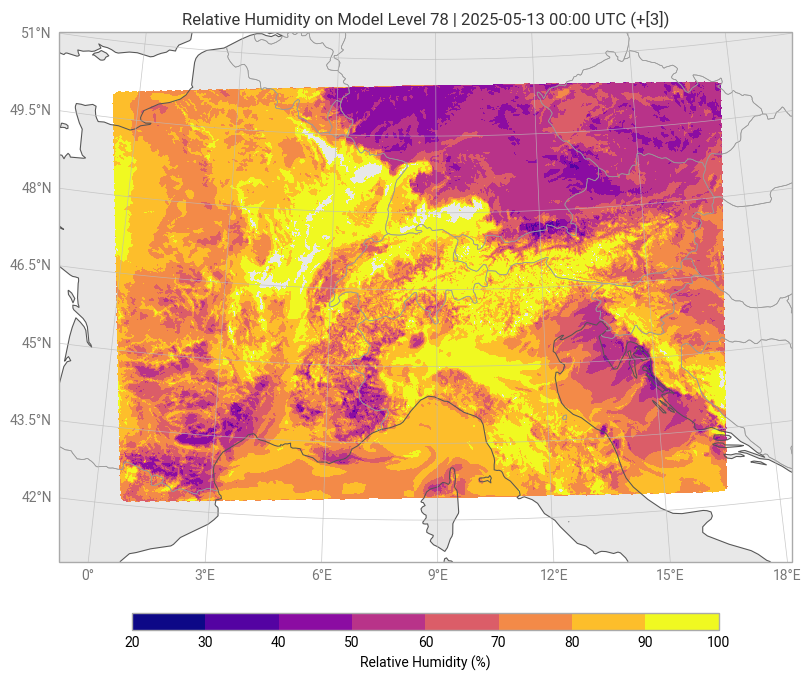

In [9]:
from earthkit.plots.geo import domains
import earthkit
import pandas as pd

# Define the map domain using the regridded data's bounding box
domain = domains.Domain.from_bbox(
    bbox=[xmin, xmax, ymin, ymax],
    name="CH2"
)

# Create the map instance
chart = earthkit.plots.Map(domain=domain)

# Plot the regridded precipitation field
chart.grid_cells(relhum_geo, x="lon", y="lat")

# Add standard map features
chart.land()
chart.coastlines()
chart.borders()
chart.gridlines()

# Extract forecast metadata
ref_time = pd.to_datetime(relhum_geo.coords["ref_time"].values[0]).strftime("%Y-%m-%d %H:%M UTC")
lead_time = relhum_geo.coords["lead_time"].values.astype('timedelta64[h]')

# Prepare title and legend labels
parameter = relhum_geo.attrs["parameter"]
title = f"{parameter['name']} on Model Level {relhum_geo.z.values} | {ref_time} (+{lead_time})"
legend_label = f"{parameter['name']} ({parameter['units']})"

# Add title and legend to the map
chart.title(title)
chart.legend(label=legend_label)

# Display the map
chart.show()